In [1]:
using PyPlot, Statistics
using MARGO

In [5]:
] add DataFrames CSV

 Resolving package versions...
  Updating `~/Documents/code/MARGO.jl/Project.toml`
  [336ed68f] + CSV v0.6.2
  [a93c6f00] + DataFrames v0.21.1
  Updating `~/Documents/code/MARGO.jl/Manifest.toml`
  [336ed68f] + CSV v0.6.2
  [324d7699] + CategoricalArrays v0.8.1
  [34da2185] + Compat v3.10.0
  [9a962f9c] + DataAPI v1.3.0
  [a93c6f00] + DataFrames v0.21.1
  [e2d170a0] + DataValueInterfaces v1.0.0
  [48062228] + FilePathsBase v0.8.0
  [41ab1584] + InvertedIndices v1.0.0
  [82899510] + IteratorInterfaceExtensions v1.0.0
  [e1d29d7a] + Missings v0.4.3
  [2dfb63ee] + PooledArrays v0.5.3
  [a2af1166] + SortingAlgorithms v0.3.1
  [3783bdb8] + TableTraits v1.0.0
  [bd369af6] + Tables v1.0.4
  [ea10d353] + WeakRefStrings v0.6.2
  [8bb1440f] + DelimitedFiles 
  [9fa8497b] + Future 
  [1a1011a3] + SharedArrays 


In [6]:
using DataFrames, CSV

┌ Info: Precompiling DataFrames [a93c6f00-e57d-5684-b7b6-d8193f3e46c0]
└ @ Base loading.jl:1273
┌ Info: Precompiling CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1273


In [9]:
run(`wget https://raw.githubusercontent.com/hdrake/cmip6-temperature-demo/cmip5_gmst/data/cmip5_rcp85_gmst.csv`)

--2020-05-28 15:54:09--  https://raw.githubusercontent.com/hdrake/cmip6-temperature-demo/cmip5_gmst/data/cmip5_rcp85_gmst.csv
Resolving raw.githubusercontent.com... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 172938 (169K) [text/plain]
Saving to: ‘cmip5_rcp85_gmst.csv’

     0K .......... .......... .......... .......... .......... 29% 2.13M 0s
    50K .......... .......... .......... .......... .......... 59% 5.12M 0s
   100K .......... .......... .......... .......... .......... 88% 8.26M 0s
   150K .......... ........                                   100% 11.0M=0.04s

2020-05-28 15:54:10 (4.12 MB/s) - ‘cmip5_rcp85_gmst.csv’ saved [172938/172938]



Process(`wget https://raw.githubusercontent.com/hdrake/cmip6-temperature-demo/cmip5_gmst/data/cmip5_rcp85_gmst.csv`, ProcessExited(0))

In [10]:
data_path = "cmip5_rcp85_gmst.csv"
data = CSV.read(data_path);

years = data[:,2];
gmst = Array(data[:, 3:end]);
gmst[ismissing.(gmst)] .= NaN;

In [12]:
function DICE_EBM(t, F; ζ = [0.098, 3.8/2.9, 0.088, 0.025], physics=nothing, default="DICE-2013r", Δt = nothing)    
    if isnothing(physics)
        if default == "Geoffroy-2013"
            physics = Dict("Δt" => Δt, "Cu" => 7.3, "Cd" => 106., "κ" => 0.73, "B" => 1.13)
        elseif default == "Geoffroy-NoMixing"
            physics = Dict("Δt" => Δt, "Cu" => 7.3, "Cd" => 106., "κ" => 0.0, "B" => 1.13)
        elseif default == "MARGO"
            physics = Dict("Δt" => Δt, "Cu" => 0., "Cd" => 106., "κ" => 0.73, "B" => 1.13)
        elseif default == "DICE-2013r"
            physics = nothing
        elseif default == "DICE-NoMixing"
            physics = nothing
            ζ[3] = 0.
        end
    end
        
    if !isnothing(physics)
        ζ[1] = Δt/physics["Cu"]
        ζ[2] = physics["B"]
        ζ[3] = physics["κ"]
        ζ[4] = physics["κ"]*physics["Δt"]/physics["Cd"]
    end
    
    T = zeros(size(t))
    T_LO = zeros(size(t))
    
    for i = 1:length(model.domain)-1
        if ζ[1] == Inf
            T[i+1] = (F[i] + ζ[3]*T_LO[i]) / (ζ[2] + ζ[3])
        else
            T[i+1] = T[i] + ζ[1]*(F[i] - ζ[2]*T[i] - ζ[3]*(T[i] - T_LO[i]))
        end
        T_LO[i+1] = T_LO[i] + ζ[4]*(T[i] - T_LO[i])
    end
    
    return T
end; 

### Stylized Extended RCP8.5 (ECP8.5) scenario

In [13]:
Δt = 5.
t = collect(1850.:Δt:3000.)

CO2e = zeros(size(t));
q = zeros(size(t));

# Construct CO2e following RCP8.5 until 2100
# https://www.iiasa.ac.at/web-apps/tnt/RcpDb/dsd?Action=htmlpage&page=compare
CO2e[t .<= 2100] = (280. .+ (1350. - 280.) .* exp.((t .- 2100.)/(37.5)))[t .<= 2100];

# Take derivation to estimate q
q[1:size(t[t .<= 2100][1:end-1], 1)] = diff(CO2e[t .<= 2100])/Δt

# Extend according to ECP85 scenario that has emissions linearly decreasing to zero by 2150.
qmax = q[size(t[t .<= 2100][1:end-1], 1)]
q[(t .>= 2100) .& (t .< 2120)] .= qmax
q[t .>= 2120] = (qmax * (1 .- (t .- 2120.)/(2200. - 2120.)))[t .>= 2120]
q[q .< 0.] .= 0.;

model = ClimateModel(t = t, dt=Δt);
model.economics.baseline_emissions = q/model.physics.r;
model.physics.δT_init = 0.;
model.physics.CO₂_init = 280.;

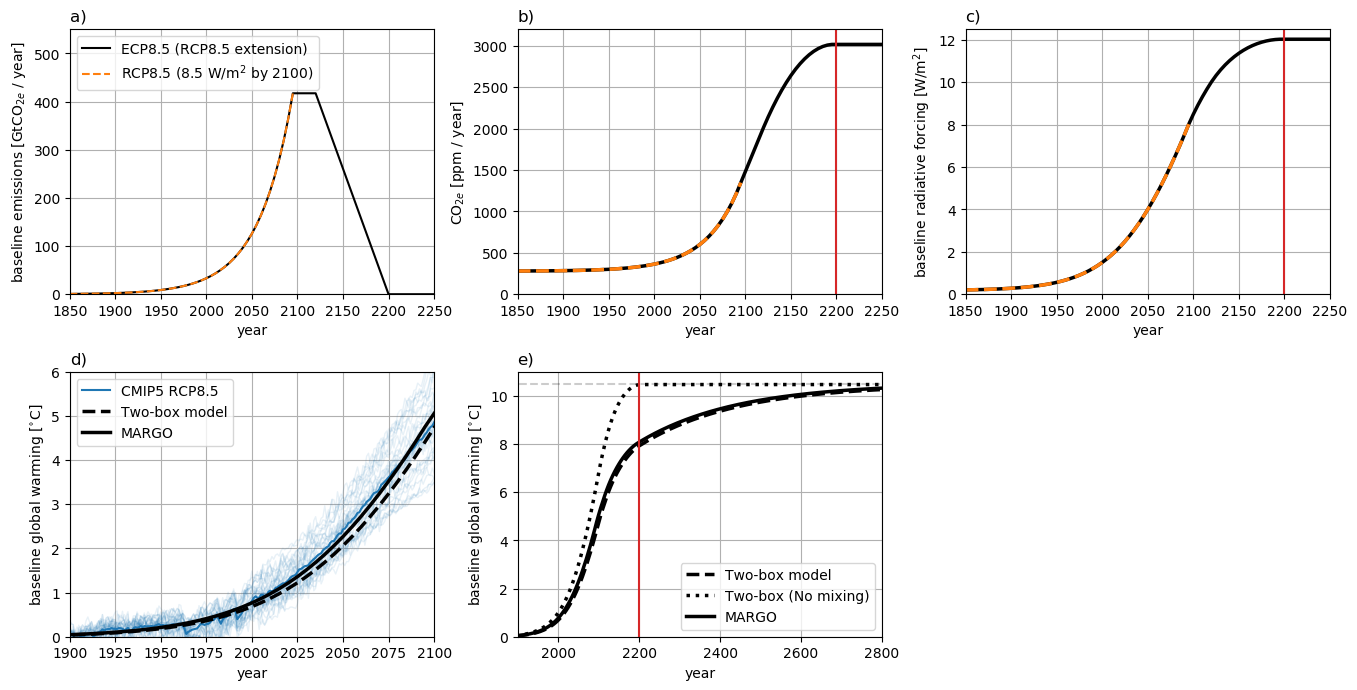

In [15]:
sec_per_year = MARGO.sec_per_year

figure(figsize=(13.5,7))


subplot(2,3,5)
plot(t, DICE_EBM(t, MARGO.FCO₂(model)/sec_per_year, default="Geoffroy-2013", Δt=Δt), "k--", lw=2.5, label="Two-box model")
plot(t, DICE_EBM(t, MARGO.FCO₂(model)/sec_per_year, default="Geoffroy-NoMixing", Δt=Δt), "k:", lw=2.5, label="Two-box (No mixing)")
plot(model.domain, MARGO.δT(model), lw=2.5, "k-", label="MARGO")

plot([1850, 3000], maximum(MARGO.FCO₂(model))/MARGO.B*[1,1], "k--", alpha=0.2)

xlim(1900, 2800)
ylim([0, 11.])
plot([2200, 2200], [0, 11], "C3-")
grid(true)
legend()
ylabel(L"baseline global warming [$^{\circ}$C]")
xlabel("year")
MARGO.add_label("e)")

subplot(2,3,4)
for i=1:size(gmst, 2)
    plot(years, gmst[:, i], "C0-", lw=1., alpha=0.1)
end
plot(years, mean(gmst[:, :], dims=2), "C0-")
plot([],[],"C0-", label="CMIP5 RCP8.5")
plot(t, DICE_EBM(t, MARGO.FCO₂(model)/sec_per_year, default="Geoffroy-2013", Δt=Δt), "k--", lw=2.5, label="Two-box model")
plot(model.domain, MARGO.δT(model), lw=2.5, "k-", label="MARGO")
xlim(1900, 2100)
ylim([0, 6.])
grid(true)
legend()
ylabel(L"baseline global warming [$^{\circ}$C]")
xlabel("year")
MARGO.add_label("d)")

subplot(2,3,3)
plot(model.domain, MARGO.FCO₂(model)/sec_per_year .+ 0.2, lw=2.5, "k-")
plot(model.domain[model.domain .< 2100], MARGO.FCO₂(model)[model.domain .< 2100]/sec_per_year .+ 0.2, lw=2.5, "C1--")
plot([2200, 2200], [0, 14.], "C3-")
ylim([0., 12.5])
xlim(1850, 2250)
grid(true)
ylabel(L"baseline radiative forcing [W/m$^{2}$]")
xlabel("year")
MARGO.add_label("c)")

subplot(2,3,2)
plot(model.domain, MARGO.CO₂(model), lw=2.5, "k-")
plot(model.domain[model.domain .< 2100], MARGO.CO₂(model)[model.domain .< 2100], lw=2.5, "C1--")
plot([2200, 2200], [0, 3200.], "C3-")
ylim([0., 3200.])
xlim(1850, 2250)
grid(true)
ylabel(L"CO$_{2e}$ [ppm / year]")
xlabel("year")
MARGO.add_label("b)")

subplot(2,3,1)
plot(model.domain, MARGO.ppm_to_GtCO2(model.economics.baseline_emissions), "k-", label="ECP8.5 (RCP8.5 extension)")
plot(model.domain[model.domain .< 2100], MARGO.ppm_to_GtCO2(model.economics.baseline_emissions)[model.domain .< 2100], "C1--", label=L"RCP8.5 (8.5 W/m$^{2}$ by 2100)")
ylim([0, 550])
xlim(1850, 2250)
grid(true)
legend(loc="upper left")
ylabel(L"baseline emissions [GtCO$_{2e}$ / year]")
xlabel("year")
MARGO.add_label("a)")

tight_layout()
#savefig("../figures/MARGO_CMIP5_validation.pdf", dpi=200, bbox_inches="tight")

### Rapid spin-up of geoengineering scenario

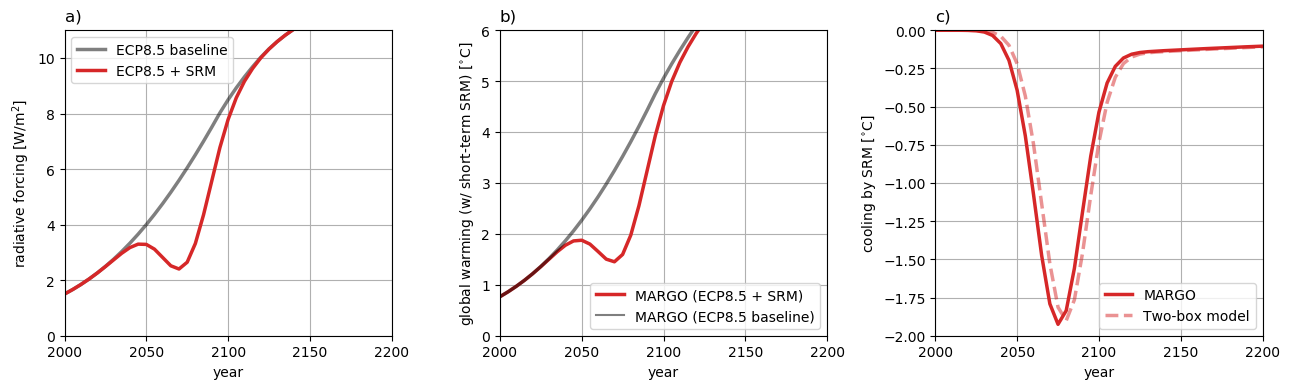

In [16]:
G = zeros(size(t))
G = 0.4 .* exp.(-(t .- 2075).^2 / 20^2)
model.controls.geoeng = G

figure(figsize=(13,4.))
subplot(1,3,1)
plot(model.domain, MARGO.FCO₂_baseline(model)/sec_per_year .+ 0.2, lw=2.5, "k-", alpha=0.5, label="ECP8.5 baseline")
plot(model.domain, MARGO.FCO₂(model)/sec_per_year .+ 0.2, lw=2.5, "C3-", label="ECP8.5 + SRM")
ylim([0., 11.])
xlim(2000, 2200)
grid(true)
ylabel(L"radiative forcing [W/m$^{2}$]")
xlabel("year")
legend()
MARGO.add_label("a)")

subplot(1,3,2)
plot(model.domain, MARGO.δT(model), lw=2.5, "C3-", label="MARGO (ECP8.5 + SRM)")
plot(model.domain, MARGO.δT_baseline(model), lw=2.5, "k-", alpha=0.5)
plot([], [], "k-", alpha=0.5, label="MARGO (ECP8.5 baseline)")
xlim(2000, 2200)
ylim([0, 6.])
grid(true)
legend()
ylabel(L"global warming (w/ short-term SRM) [$^{\circ}$C]")
xlabel("year")
MARGO.add_label("b)")

subplot(1,3,3)
plot(model.domain, MARGO.δT(model) .- MARGO.δT_baseline(model), lw=2.5, "C3-", label="MARGO")
plot(
    t,
    DICE_EBM(t, MARGO.FCO₂(model)/sec_per_year, default="Geoffroy-2013", Δt=Δt) .-
    DICE_EBM(t, MARGO.FCO₂_baseline(model)/sec_per_year, default="Geoffroy-2013", Δt=Δt),
    "C3--", lw=2.5, alpha=0.5, label="Two-box model"
)
xlim(2000, 2200)
ylim([-2, 0.])
grid(true)
legend()
ylabel(L"cooling by SRM [$^{\circ}$C]")
xlabel("year")
MARGO.add_label("c)")

tight_layout()
#savefig("../figures/MARGO_SRM_validation.pdf", dpi=200, bbox_inches="tight")